In [10]:
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Define datasets and directions
datasets = [
    "b4bqa"
    # orig filtered
    "medmcqa_orig_filtered",
    "medqa_4options_orig_filtered",
    "mmlu_clinical_knowledge_orig_filtered",
    "mmlu_professional_medicine_orig_filtered",
    # b2g
    "medqa_4options_b2g",
    "mmlu_clinical_knowledge_b2g",
    "mmlu_professional_medicine_b2g",
    # g2b
    "medqa_4options_g2b",
    "mmlu_clinical_knowledge_g2b",
    "mmlu_professional_medicine_g2b",
]

models = [
    "microsoft/phi-1",
    "microsoft/phi-1_5",
    "microsoft/phi-2",
    "microsoft/Phi-3-medium-4k-instruct",
    "mistralai/Mistral-7B-v0.3",
    "Qwen/Qwen1.5-7B",
    "meta-llama/Llama-2-7b-hf",
    "meta-llama/Meta-Llama-3-8B",
    "mistralai/Mixtral-8x7B-v0.1",
    "mistralai/Mixtral-8x22B-v0.1",
    "meta-llama/Llama-2-70B-hf",
    "meta-llama/Meta-Llama-3-70B",
    "Qwen/Qwen1.5-72B",
    "CohereForAI/c4ai-command-r-plus",
    "CohereForAI/aya-23-35B",
    "Qwen/Qwen2-72B",
    "Qwen/Qwen2-7B",
    "Qwen/Qwen1.5-110B",
]

# Define a dictionary to map the original dataset names to the new names
model_name_map = {
    "microsoft-phi-1": "phi-1",
    "microsoft-phi-1_5": "phi-1_5",
    "microsoft-phi-2": "phi-2",
    "microsoft-Phi-3-medium-4k-instruct": "phi-3-medium",
    "CohereForAI-aya-23-35B": "c4ai-aya-23-35B",
    "CohereForAI-c4ai-command-r-plus": "c4ai-r-plus",
    "meta-llama-Llama-2-70B-hf": "llama-2-70B",
    "meta-llama-Llama-2-7b-hf": "llama-2-7B",
    "meta-llama-Meta-Llama-3-70B": "llama-3-70B",
    "meta-llama-Meta-Llama-3-8B": "llama-3-8B",
    "mistralai-Mixtral-8x22B-v0.1": "mixtral-8x22B",
    "mistralai-Mixtral-8x7B-v0.1": "mixtral-8x7B",
    "mistralai-Mistral-7B-v0.3": "mistral-7B",
    "Qwen-Qwen1.5-72B": "qwen1.5-72B",
    "Qwen-Qwen1.5-7B": "qwen1.5-7B",
    "Qwen-Qwen2-72B": "qwen1.5-72B",
    "Qwen-Qwen2-7B": "qwen1.5-7B",
    "Qwen-Qwen1.5-110B": "qwen1.5-110B",
}


model_size_map = {
    "phi-1": "1.3",
    "phi-1_5": "1.3",
    "phi-2": "2.7",
    "phi-3-medium": "14",
    "c4ai-aya-23-35B": "35",
    "c4ai-r-plus": "104",
    "llama-2-70B": "70",
    "llama-2-7B": "7",
    "llama-3-70B": "70",
    "llama-3-8B": "8",
    "mixtral-8x22B": "176",
    "mixtral-8x7B": "56",
    "mistral-7B": "7",
    "qwen1.5-72B": "72",
    "qwen1.5-7B": "7",
    "qwen2-72B": "72",
    "qwen2-7B": "7",
    "qwen1.5-110B": "110",
}


replacement_directions = ["brand_to_generic", "generic_to_brand", "none"]

## Model results


In [35]:
def load_model_results(model, direction):
    """
    Load the model results from a JSON file.

    Args:
    model (str): The model name.
    direction (str): The direction of replacements (e.g., brand_to_generic, generic_to_brand).

    Returns:
    pd.DataFrame: A DataFrame containing the model results.
    """
    results_file_path = f"b4b/{model}_results.json"

    if os.path.exists(results_file_path):
        with open(results_file_path, "r") as file:
            results_data = json.load(file)

        results = results_data["results"]
        results_list = []

        for dataset, metrics in results.items():
            for metric, value in metrics.items():
                if metric.startswith("acc"):
                    metric_name = metric.split(",")[0]
                    results_list.append([dataset, metric_name, value])

        df_results = pd.DataFrame(results_list, columns=["Dataset", "Metric", "Value"])
        df_results["Model"] = model
        df_results["Dataset"] = df_results["Dataset"]

        return df_results
    else:
        return pd.DataFrame(columns=["Dataset", "Metric", "Value", "Model"])


def process_results(results_df):
    # Wrangle names to get pairs
    results_df["Direction"] = results_df["Dataset"].apply(
        lambda x: (
            "brand_to_generic"
            if "b2g" in x
            else "generic_to_brand" if "g2b" in x else "none"
        )
    )

    # If _b2g, _g2b, or b4b_ in name remove it from the name
    for term in ["_b2g", "_g2b", "b4b_", "_orig_filtered"]:
        results_df["Dataset"] = results_df["Dataset"].apply(
            lambda x: x.replace(term, "")
        )

    # Filter the results DataFrame to include only accuracy metrics
    results_df_filtered = results_df[results_df["Metric"] == "acc"]

    # filter out datasets if not contain medmcqa, medqa
    results_df_filtered = results_df_filtered[
        results_df_filtered["Dataset"].str.contains("medmcqa|medqa")
    ]

    # Pivot the DataFrame to have directions as columns
    pivot_results = results_df_filtered.pivot_table(
        index=["Dataset", "Model"], columns="Direction", values="Value"
    ).reset_index()

    # Replace 'b4b' with NaN
    pivot_results.replace("b4b", np.nan, inplace=True)

    # Drop the row with NaN
    pivot_results.dropna(subset=["Dataset"], inplace=True)

    # Calculate the average for each model
    average_df = (
        pivot_results.groupby("Model")[["brand_to_generic", "generic_to_brand", "none"]]
        .mean()
        .reset_index()
    )

    # Assign the averages to 'b4b' dataset
    average_df["Dataset"] = "b4b"

    # Append the averages to the original DataFrame
    pivot_results = pd.concat([pivot_results, average_df], ignore_index=True)

    return pivot_results

In [36]:
# Initialize an empty DataFrame to store the final results
results_df = pd.DataFrame(columns=["Dataset", "Metric", "Value", "Model"])

# replace model / with - in the model name
for i in range(len(models)):
    models[i] = models[i].replace("/", "-")

# Load and store the model results
for model in models:
    for direction in replacement_directions:
        df_model_results = load_model_results(model, direction)
        if not df_model_results.empty:
            results_df = pd.concat([results_df, df_model_results], ignore_index=True)

# Save the results to a CSV file
results_output_file_path = "tables/all_model_results.csv"
results_df.to_csv(results_output_file_path, index=False)

print("\nModel Results found:")
print(results_df["Model"].unique())

processed_results = process_results(results_df)

# Assume processed_results is a pandas DataFrame and 'Model' is one of its columns
processed_results["Model"] = (
    processed_results["Model"].map(model_name_map).fillna(processed_results["Model"])
)


# sort by dataset and model
processed_results = processed_results.sort_values(by=["Dataset", "Model"])

processed_results_output_file_path = "tables/processed_model_results.csv"

# Save the processed results to a CSV file
processed_results.to_csv(processed_results_output_file_path, index=False)
processed_results


Model Results found:
['microsoft-phi-1' 'microsoft-phi-1_5' 'microsoft-phi-2'
 'microsoft-Phi-3-medium-4k-instruct' 'mistralai-Mistral-7B-v0.3'
 'Qwen-Qwen1.5-7B' 'meta-llama-Llama-2-7b-hf' 'meta-llama-Meta-Llama-3-8B'
 'mistralai-Mixtral-8x7B-v0.1' 'mistralai-Mixtral-8x22B-v0.1'
 'meta-llama-Llama-2-70B-hf' 'meta-llama-Meta-Llama-3-70B'
 'Qwen-Qwen1.5-72B' 'CohereForAI-c4ai-command-r-plus'
 'CohereForAI-aya-23-35B']


Direction,Dataset,Model,brand_to_generic,generic_to_brand,none
30,b4b,c4ai-aya-23-35B,0.529707,0.464395,0.530684
31,b4b,c4ai-r-plus,0.603753,0.515631,0.607721
34,b4b,llama-2-70B,0.530574,0.460271,0.530574
35,b4b,llama-2-7B,0.344808,0.336966,0.343832
36,b4b,llama-3-70B,0.762858,0.686609,0.765834
37,b4b,llama-3-8B,0.600808,0.515678,0.607737
42,b4b,mistral-7B,0.537652,0.455529,0.537659
43,b4b,mixtral-8x22B,0.697608,0.606565,0.703545
44,b4b,mixtral-8x7B,0.621571,0.532551,0.624555
39,b4b,phi-1,0.252047,0.261905,0.250062


get b4b qa results

In [46]:
results_df
# keep only rows where Dataset=='b4bqa' and Metric=='acc'
b4bqa_results = results_df[(results_df["Dataset"] == "b4bqa") & (results_df["Metric"] == "acc")]
# deduplicate the results
b4bqa_results = b4bqa_results.drop_duplicates(subset=["Model"])
# sort the results by Model size
b4bqa_results["Model Size"] = b4bqa_results["Model"].map(model_name_map).map(model_size_map)
b4bqa_results['Model Size'] = pd.to_numeric(b4bqa_results['Model Size'])
b4bqa_results = b4bqa_results.sort_values(by="Model Size")

# drop column direction and metric
b4bqa_results = b4bqa_results.drop(columns=["Direction", "Metric", "Dataset"])

b4bqa_results

,Value,Model,Model Size
4,0.196429,microsoft-phi-1,1.3
118,0.280134,microsoft-phi-1_5,1.3
232,0.474888,microsoft-phi-2,2.7
460,0.703125,mistralai-Mistral-7B-v0.3,7.0
574,0.729353,Qwen-Qwen1.5-7B,7.0
688,0.367188,meta-llama-Llama-2-7b-hf,7.0
802,0.827567,meta-llama-Meta-Llama-3-8B,8.0
346,0.699219,microsoft-Phi-3-medium-4k-instruct,14.0
1600,0.786272,CohereForAI-aya-23-35B,35.0
916,0.861607,mistralai-Mixtral-8x7B-v0.1,56.0


/tmp/ipykernel_771827/2247738781.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Value', data=b4bqa_results, palette='viridis')


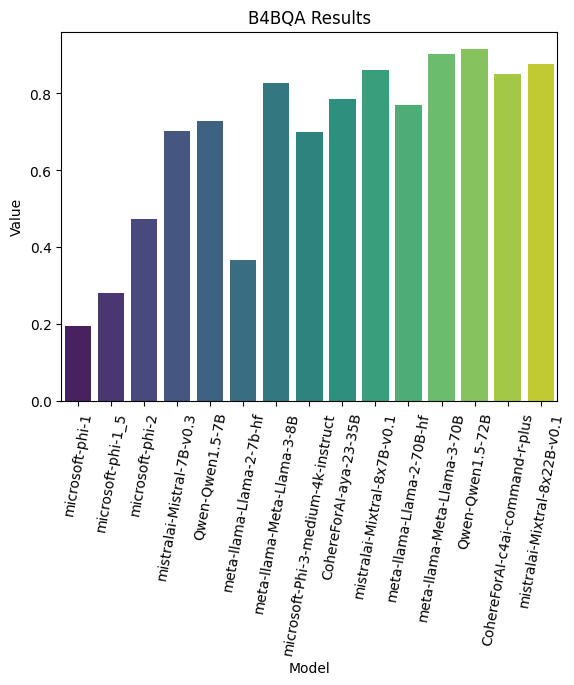

In [49]:
sns.barplot(x='Model', y='Value', data=b4bqa_results, palette='viridis')

plt.title('B4BQA Results')
plt.xlabel('Model')
plt.ylabel('Value')
plt.xticks(rotation=80)  # Rotate x-axis labels for better readability

plt.show()

## Latex tables

#### Dataset | Model | brand_to_generic | generic_to_brand | none


In [31]:
# Generate LaTeX table
latex_table = processed_results.to_latex(index=False, float_format="%.3f")

# Save LaTeX table to a file
with open("tables/model_results_table.tex", "w") as f:
    f.write(latex_table)
# Print the LaTeX table
## # Dataset | Model | brand_to_generic | generic_to_brand | none
print(latex_table)

\begin{tabular}{llrrr}
\toprule
Dataset & Model & brand_to_generic & generic_to_brand & none \\
\midrule
b4b & c4ai-aya-23-35B & 0.530 & 0.464 & 0.531 \\
b4b & c4ai-r-plus & 0.604 & 0.516 & 0.608 \\
b4b & llama-2-70B & 0.531 & 0.460 & 0.531 \\
b4b & llama-2-7B & 0.345 & 0.337 & 0.344 \\
b4b & llama-3-70B & 0.763 & 0.687 & 0.766 \\
b4b & llama-3-8B & 0.601 & 0.516 & 0.608 \\
b4b & mistral-7B & 0.538 & 0.456 & 0.538 \\
b4b & mixtral-8x22B & 0.698 & 0.607 & 0.704 \\
b4b & mixtral-8x7B & 0.622 & 0.533 & 0.625 \\
b4b & phi-1 & 0.252 & 0.262 & 0.250 \\
b4b & phi-1_5 & 0.319 & 0.322 & 0.319 \\
b4b & phi-2 & 0.421 & 0.361 & 0.420 \\
b4b & phi-3-medium & 0.654 & 0.543 & 0.656 \\
b4b & qwen1.5-72B & 0.673 & 0.584 & 0.674 \\
b4b & qwen1.5-7B & 0.513 & 0.455 & 0.515 \\
medmcqa & c4ai-aya-23-35B & 0.546 & 0.456 & 0.544 \\
medmcqa & c4ai-r-plus & 0.603 & 0.470 & 0.611 \\
medmcqa & llama-2-70B & 0.516 & 0.409 & 0.516 \\
medmcqa & llama-2-7B & 0.331 & 0.339 & 0.333 \\
medmcqa & llama-3-70B & 0.766 & 0

### Model | none | generic_to_brand | Average | Difference


In [32]:
# Filter for the 'b4b' dataset
b4b_results = processed_results[processed_results["Dataset"] == "b4b"].copy()

# Calculate the average of original (none) and generic to brand
b4b_results["Average"] = b4b_results[["none", "generic_to_brand"]].mean(axis=1)

# Calculate the difference
b4b_results["Difference"] = b4b_results["generic_to_brand"] - b4b_results["none"]

# Select relevant columns for the LaTeX table
b4b_results = b4b_results[
    ["Model", "none", "generic_to_brand", "Average", "Difference"]
]

# Generate LaTeX table
latex_table_b4b = b4b_results.to_latex(index=False, float_format="%.3f")

# Save LaTeX table to a file
with open("tables/b4b_results_table.tex", "w") as f:
    f.write(latex_table_b4b)

# Print the LaTeX table
## # Model | none | generic_to_brand | Average | Difference
print(latex_table_b4b)

\begin{tabular}{lrrrr}
\toprule
Model & none & generic_to_brand & Average & Difference \\
\midrule
c4ai-aya-23-35B & 0.531 & 0.464 & 0.498 & -0.066 \\
c4ai-r-plus & 0.608 & 0.516 & 0.562 & -0.092 \\
llama-2-70B & 0.531 & 0.460 & 0.495 & -0.070 \\
llama-2-7B & 0.344 & 0.337 & 0.340 & -0.007 \\
llama-3-70B & 0.766 & 0.687 & 0.726 & -0.079 \\
llama-3-8B & 0.608 & 0.516 & 0.562 & -0.092 \\
mistral-7B & 0.538 & 0.456 & 0.497 & -0.082 \\
mixtral-8x22B & 0.704 & 0.607 & 0.655 & -0.097 \\
mixtral-8x7B & 0.625 & 0.533 & 0.579 & -0.092 \\
phi-1 & 0.250 & 0.262 & 0.256 & 0.012 \\
phi-1_5 & 0.319 & 0.322 & 0.321 & 0.003 \\
phi-2 & 0.420 & 0.361 & 0.390 & -0.059 \\
phi-3-medium & 0.656 & 0.543 & 0.599 & -0.114 \\
qwen1.5-72B & 0.674 & 0.584 & 0.629 & -0.090 \\
qwen1.5-7B & 0.515 & 0.455 & 0.485 & -0.060 \\
\bottomrule
\end{tabular}



## Visualise difference in performance


In [33]:
# Calculate the differences
processed_results["Diff_brand_to_generic"] = (
    processed_results["brand_to_generic"] - processed_results["none"]
)
processed_results["Diff_generic_to_brand"] = (
    processed_results["generic_to_brand"] - processed_results["none"]
)

# Melt the DataFrame for plotting
melted_results = processed_results.melt(
    id_vars=["Dataset", "Model"],
    value_vars=["Diff_brand_to_generic", "Diff_generic_to_brand"],
    var_name="Direction",
    value_name="Accuracy Difference",
)

melted_results

,Dataset,Model,Direction,Accuracy Difference
0,b4b,c4ai-aya-23-35B,Diff_brand_to_generic,-0.000976
1,b4b,c4ai-r-plus,Diff_brand_to_generic,-0.003968
2,b4b,llama-2-70B,Diff_brand_to_generic,0.000000
3,b4b,llama-2-7B,Diff_brand_to_generic,0.000976
4,b4b,llama-3-70B,Diff_brand_to_generic,-0.002976
...,...,...,...,...
85,medqa_4options,phi-1_5,Diff_generic_to_brand,0.015748
86,medqa_4options,phi-2,Diff_generic_to_brand,-0.047244
87,medqa_4options,phi-3-medium,Diff_generic_to_brand,-0.064961
88,medqa_4options,qwen1.5-72B,Diff_generic_to_brand,-0.053150


/tmp/ipykernel_771827/3642326035.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results['Model Size'] = filtered_results['Model'].map(model_size_map)
/tmp/ipykernel_771827/3642326035.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results['Model Size'] = pd.to_numeric(filtered_results['Model Size'])
/tmp/ipykernel_771827/3642326035.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and se

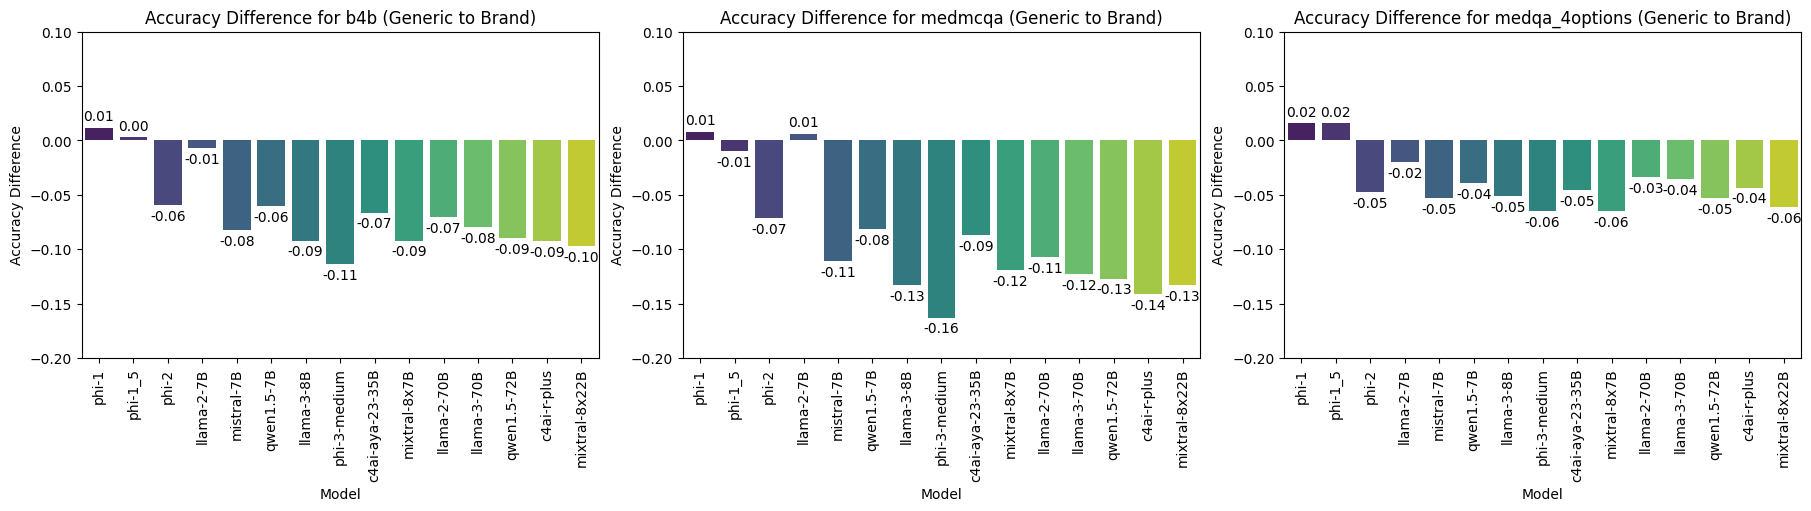

In [27]:
# Filter the DataFrame to only include 'Diff_generic_to_brand' direction
filtered_results = melted_results[
    melted_results["Direction"] == "Diff_generic_to_brand"
]

# Create a new column 'Model Size' in the DataFrame
filtered_results['Model Size'] = filtered_results['Model'].map(model_size_map)
filtered_results['Model Size'] = pd.to_numeric(filtered_results['Model Size'])

# Create bar plots for each task with filtered data
tasks = filtered_results["Dataset"].unique()
num_tasks = len(tasks)
ncols = 3  # Number of columns in the grid
nrows = (num_tasks // ncols) + (num_tasks % ncols > 0)  # Number of rows needed

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(18, nrows * 5), constrained_layout=True
)
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, task in enumerate(tasks):
    ax = axes[i]
    task_data = filtered_results[filtered_results["Dataset"] == task]
    task_data = task_data.sort_values('Model Size')  # Sort by Model Size
    sns.barplot(
        x="Model",
        y="Accuracy Difference",
        data=task_data,
        palette="viridis",
        ax=ax,
        order=task_data['Model']
    )

    # Add labels on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)

    ax.set_title(f"Accuracy Difference for {task} (Generic to Brand)")
    ax.set_xlabel("Model")
    ax.set_ylabel("Accuracy Difference")
    ax.set_ylim(-0.2, 0.1)  # Adjust the y-axis limits as needed

    # Rotate the x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Save the plot to a file
plt.savefig("plots/accuracy_difference_generic_to_brand.png")

plt.show()


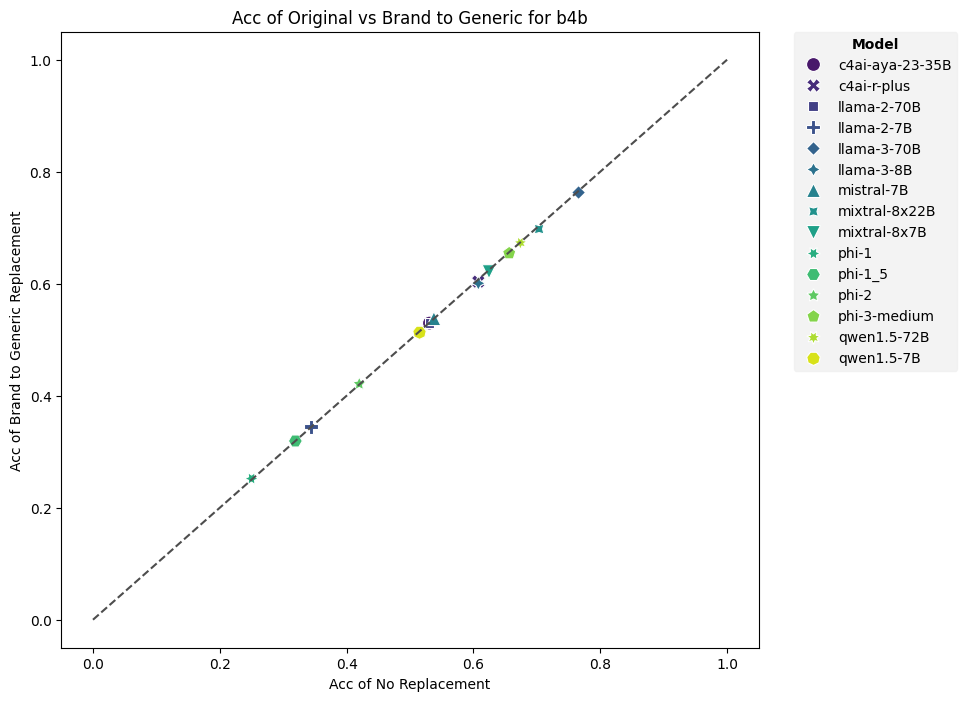

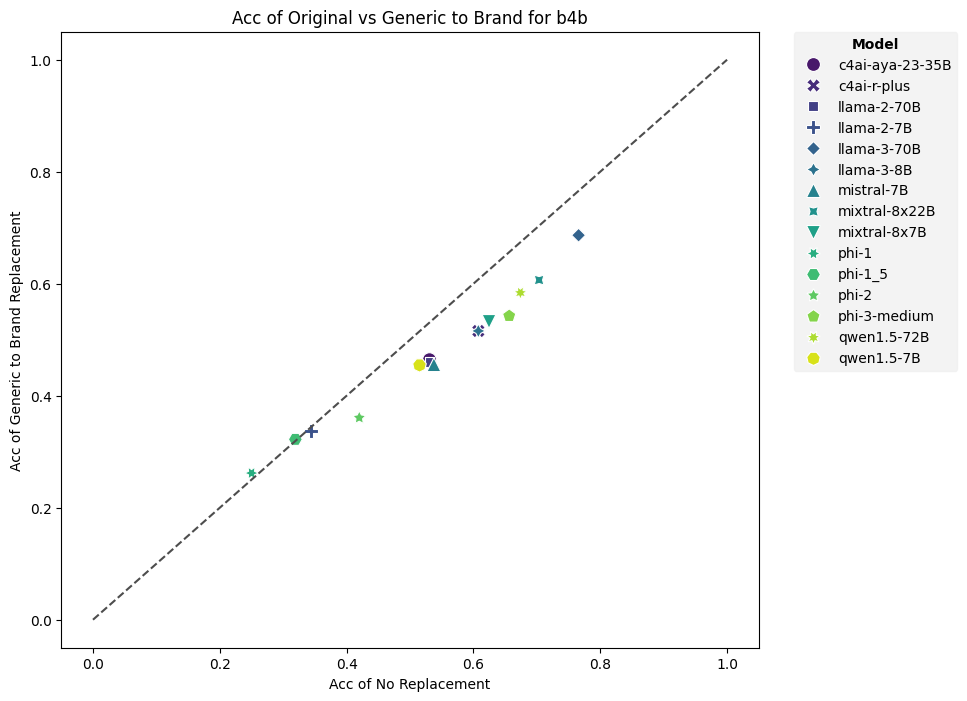

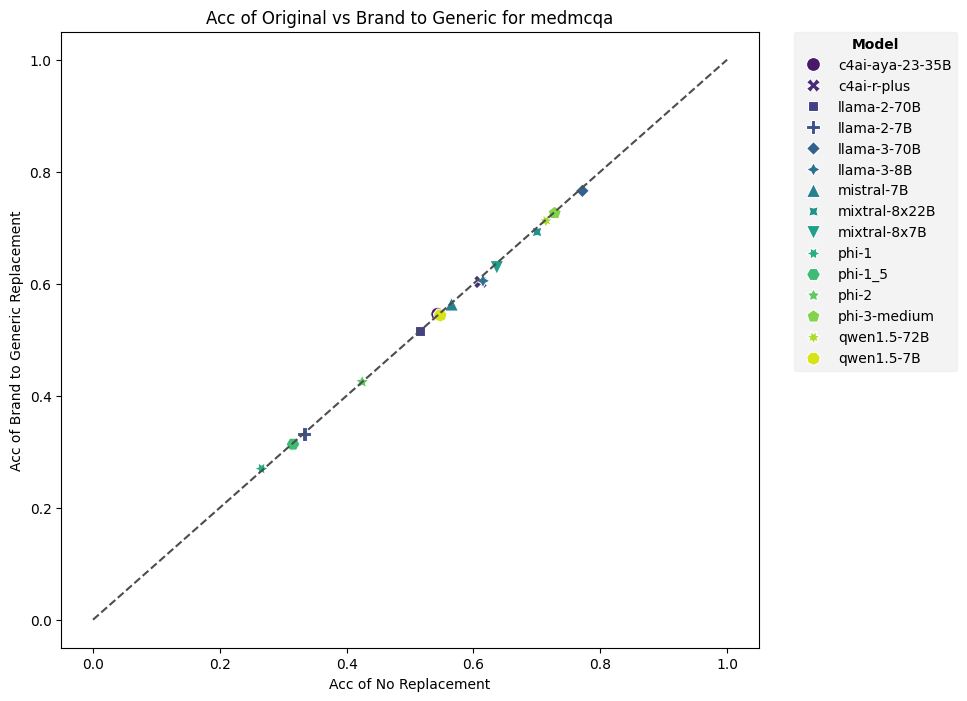

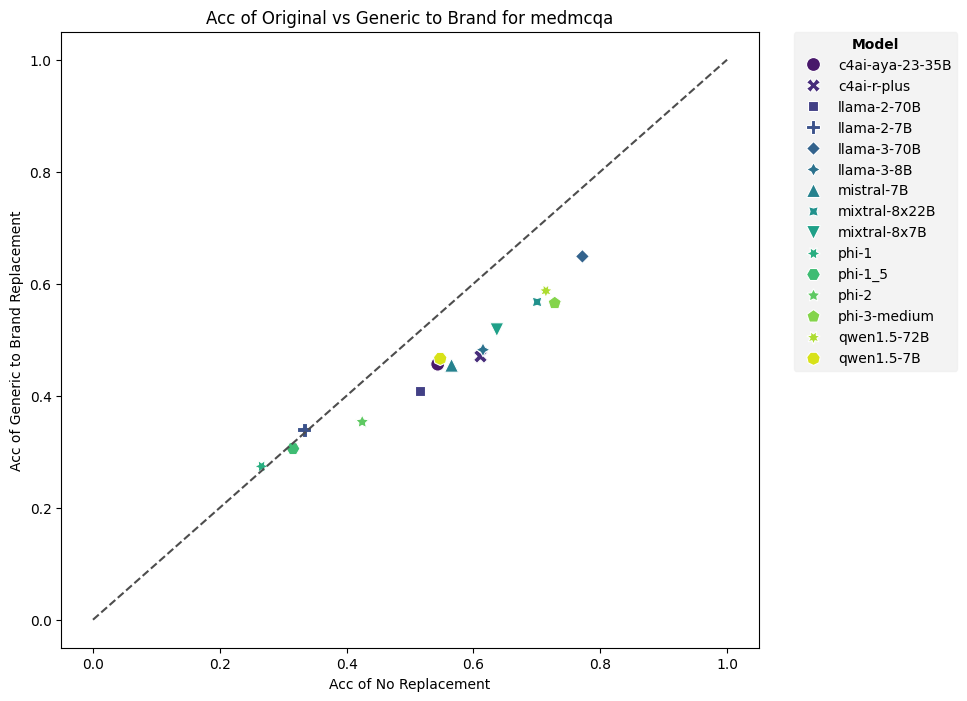

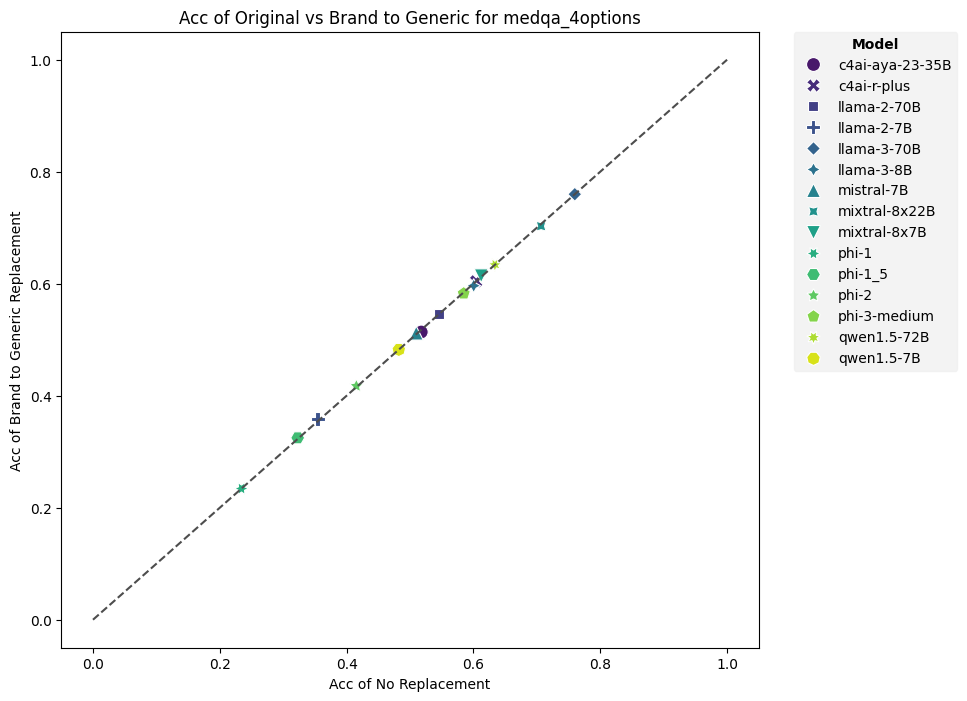

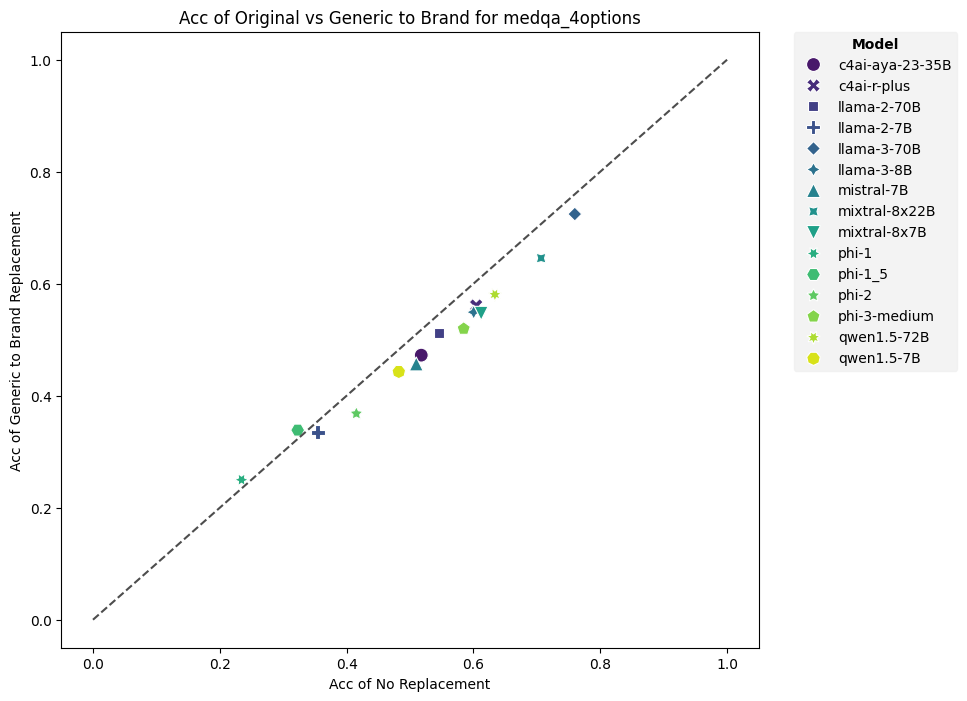

In [18]:
# Get the unique tasks
tasks = processed_results["Dataset"].unique()

for task in tasks:
    task_data = processed_results[processed_results["Dataset"] == task]

    # Setting up the figure and axis for brand_to_generic scatter plot
    plt.figure(figsize=(9, 8))
    ax1 = sns.scatterplot(
        data=task_data,
        x="none",
        y="brand_to_generic",
        hue="Model",
        style="Model",
        palette="viridis",
        s=100,
    )
    ax1.plot([0, 1], [0, 1], ls="--", c=".3")  # Diagonal line
    ax1.set_title(f"Acc of Original vs Brand to Generic for {task}")
    ax1.set_xlabel("Acc of No Replacement")
    ax1.set_ylabel("Acc of Brand to Generic Replacement")

    # Configure and place the legend outside the plot with a grey background
    legend = ax1.legend(
        title="Model", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, frameon=True
    )
    legend.get_frame().set_color("#f0f0f0")  # Set legend background color
    plt.setp(legend.get_title(), weight="bold")  # Make legend title bold

    plt.savefig(f"plots/{task}_brand_to_generic.png")
    plt.show()  # Display the plot in the notebook

    # Setting up the figure and axis for generic_to_brand scatter plot
    plt.figure(figsize=(9, 8))
    ax2 = sns.scatterplot(
        data=task_data,
        x="none",
        y="generic_to_brand",
        hue="Model",
        style="Model",
        palette="viridis",
        s=100,
    )
    ax2.plot([0, 1], [0, 1], ls="--", c=".3")  # Diagonal line
    ax2.set_title(f"Acc of Original vs Generic to Brand for {task}")
    ax2.set_xlabel("Acc of No Replacement")
    ax2.set_ylabel("Acc of Generic to Brand Replacement")

    # Configure and place the legend outside the plot with a grey background
    legend = ax2.legend(
        title="Model", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, frameon=True
    )
    legend.get_frame().set_color("#f0f0f0")  # Set legend background color
    plt.setp(legend.get_title(), weight="bold")  # Make legend title bold
    plt.savefig(f"plots/{task}_generic_to_brand.png")
    plt.show()  # Display the plot in the notebook

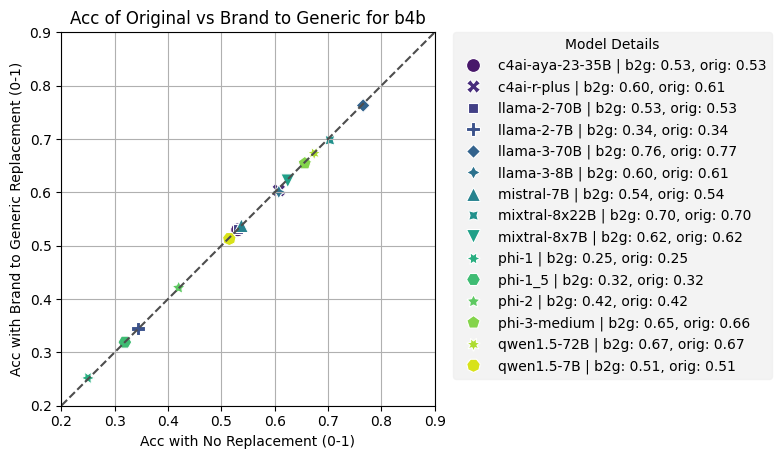

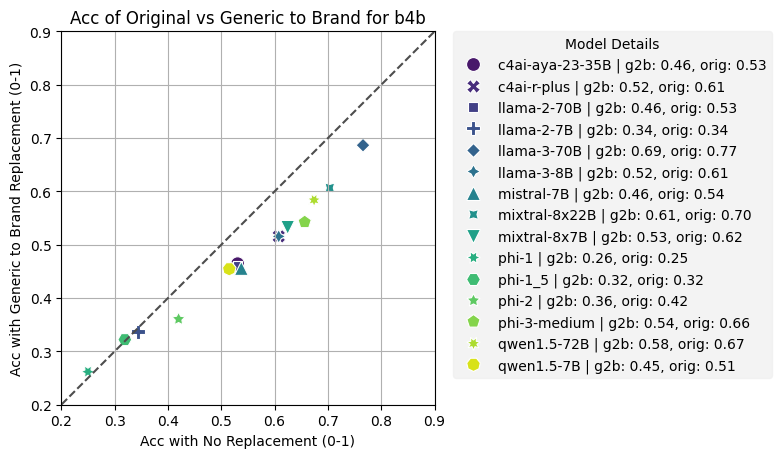

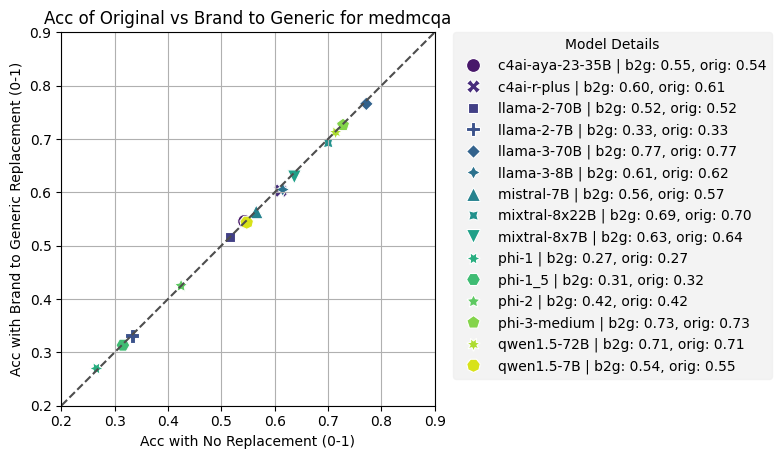

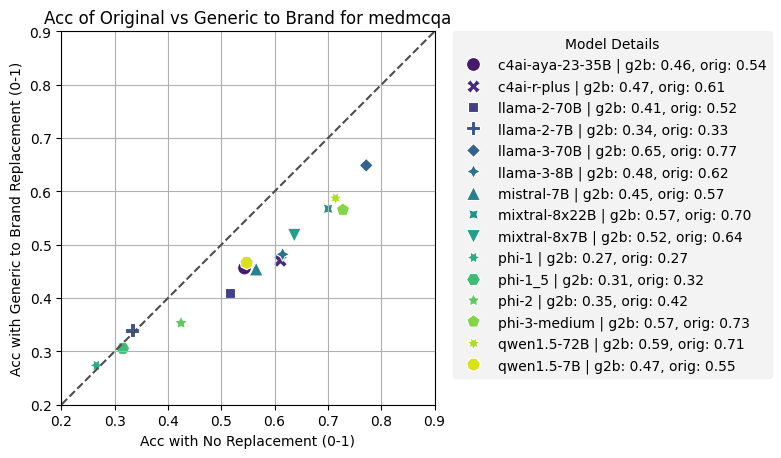

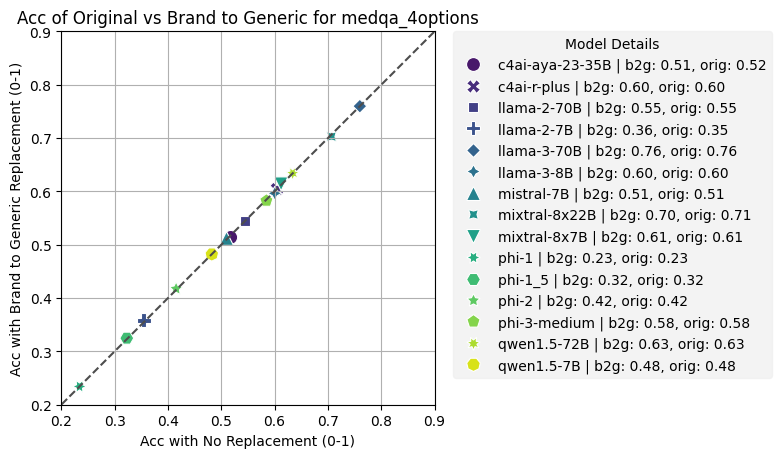

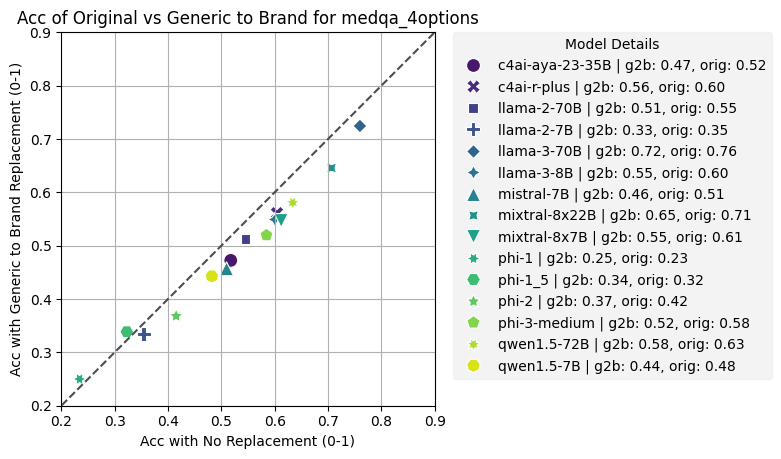

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume 'processed_results' is your DataFrame
# Create detailed labels for the legends
processed_results["Model_b2g_detail"] = processed_results.apply(
    lambda x: f"{x['Model']} | b2g: {x['brand_to_generic']:.2f}, orig: {x['none']:.2f}",
    axis=1,
)
processed_results["Model_g2b_detail"] = processed_results.apply(
    lambda x: f"{x['Model']} | g2b: {x['generic_to_brand']:.2f}, orig: {x['none']:.2f}",
    axis=1,
)

# Get the unique tasks
tasks = processed_results["Dataset"].unique()

for task in tasks:
    task_data = processed_results[processed_results["Dataset"] == task]

    # Scatter plot for brand_to_generic vs none
    plt.figure(figsize=(8, 8))
    ax1 = sns.scatterplot(
        data=task_data,
        x="none",
        y="brand_to_generic",
        hue="Model_b2g_detail",  # Use detailed label for hue
        style="Model_b2g_detail",  # Use detailed label for style
        palette="viridis",
        s=100,
    )
    ax1.set_xlim([0.2, 0.9])  # Set x-axis range
    ax1.set_ylim([0.2, 0.9])  # Se
    ax1.plot([0, 1], [0, 1], ls="--", c=".3")  # Diagonal reference line
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_title(f"Acc of Original vs Brand to Generic for {task}", loc='center')
    # fig.suptitle(f"Accuracy with Original vs Brand to Generic for {task}", y=1.02)
    ax1.set_xlabel("Acc with No Replacement (0-1)")
    ax1.set_ylabel("Acc with Brand to Generic Replacement (0-1)")
    ax1.grid(True)

    # Configure and place the legend outside the plot
    legend = ax1.legend(
        title="Model Details",
        bbox_to_anchor=(1.05, 1),
        loc=2,
        borderaxespad=0.0,
        frameon=True,
    )
    legend.get_frame().set_color("#f0f0f0")
    # tight_layout() to prevent overlapping labels
    plt.tight_layout()
    plt.savefig(f"plots/{task}_brand_to_generic.png")
    plt.show()

    # Scatter plot for generic_to_brand vs none
    plt.figure(figsize=(8, 8))
    ax2 = sns.scatterplot(
        data=task_data,
        x="none",
        y="generic_to_brand",
        hue="Model_g2b_detail",  # Use detailed label for hue
        style="Model_g2b_detail",  # Use detailed label for style
        palette="viridis",
        s=100,
    )
    ax2.set_xlim([0.2, 0.9])  # Set x-axis range
    ax2.set_ylim([0.2, 0.9])  
    ax2.plot([0, 1], [0, 1], ls="--", c=".3")  # Diagonal reference line
    ax2.set_aspect('equal', adjustable='box')
    ax2.set_title(f"Acc of Original vs Generic to Brand for {task}", loc='center')
    ax2.set_xlabel("Acc with No Replacement (0-1)")
    ax2.set_ylabel("Acc with Generic to Brand Replacement (0-1)")
    ax2.grid(True)

    # Configure and place the legend outside the plot
    legend = ax2.legend(
        title="Model Details",
        bbox_to_anchor=(1.05, 1),
        loc=2,
        borderaxespad=0.0,
        frameon=True,
    )
    legend.get_frame().set_color("#f0f0f0")
    plt.tight_layout()
    plt.savefig(f"plots/{task}_generic_to_brand.png")
    plt.show()

In [20]:
# read in keywords count for each dataset (raw file in b4b repo)
keywords_count = pd.read_csv("keywords_count_test.csv")

keywords_count

,dataset,split,n_questions,keywords,total_keyword_length,brand_keywords_count,generic_keywords_count
0,medmcqa,test,780,"['carbamide', 'ofloxacin', 'lamivudine', 'nevi...",1359,67,1292
1,bigbio/pubmed_qa,test,23,"['digoxin', 'supreme', 'methotrexate', 'fenofi...",23,1,22
2,GBaker/MedQA-USMLE-4-options-hf,test,508,"['hydrochlorothiazide', 'chlorthalidone', 'ato...",1169,16,1153
3,augtoma/usmle_step_1,test,24,"['levodopa', 'carbidopa', 'metformin', 'insuli...",39,1,38
4,augtoma/usmle_step_2,test,48,"['insulin', 'ciprofloxacin', 'fentanyl', 'prop...",89,0,89
5,augtoma/usmle_step_3,test,50,"['acyclovir', 'acyclovir', 'aspirin', 'levetir...",107,1,106
6,hails/mmlu_no_train/anatomy,test,3,"['fibrinogen', 'propel', 'insulin', 'fibrinoge...",3,1,2
7,hails/mmlu_no_train/clinical_knowledge,test,5,"['ropinirole', 'paracetamol', 'morphine', 'ins...",5,1,4
8,hails/mmlu_no_train/professional_medicine,test,56,"['sulfasalazine', 'ibuprofen', 'dextrose', 'wa...",97,0,97
